# 1. Setup

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18

tqdm.pandas()

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
language = 'Hindi'
data_dir = f'Data/{language}'
train_dir = f'{data_dir}/Train'
val_dir = f'{data_dir}/Val'
test_dir = f'{data_dir}/Test'
test_dir_v2 = f'Data/{language}-V2-Test'

In [3]:
character_df_fp = f'Data/Characters/Characters-{language}.csv'

In [4]:
cpu_count = 8 #os.cpu_count()
print(cpu_count)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

8
cuda


# 2. Define character class

In [5]:
character_df = pd.read_csv(character_df_fp)
print(character_df.shape)
character_df.head()

(374, 3)


,Character,Consonant,Glyph
0,अ,-,-
1,आ,-,ा
2,इ,-,ि
3,ई,-,ी
4,उ,-,ु


In [6]:
#character_df[character_df['Consonant']=="-"]

In [7]:
characters = set()
for character in character_df['Character'].values:
    characters.update(list(character))
characters = ["-"] + sorted(list(characters))
print(len(characters))
print(characters)

55
['-', 'अ', 'आ', 'इ', 'ई', 'उ', 'ऊ', 'ऋ', 'ए', 'ऐ', 'ओ', 'औ', 'क', 'ख', 'ग', 'घ', 'ङ', 'च', 'छ', 'ज', 'झ', 'ञ', 'ट', 'ठ', 'ड', 'ढ', 'ण', 'त', 'थ', 'द', 'ध', 'न', 'प', 'फ', 'ब', 'भ', 'म', 'य', 'र', 'ल', 'व', 'श', 'ष', 'स', 'ह', 'ा', 'ि', 'ी', 'ु', 'ू', 'ृ', 'े', 'ै', 'ो', 'ौ']


In [8]:
idx2char = {k:v for k,v in enumerate(characters)}
print(idx2char)
char2idx = {v:k for k,v in idx2char.items()}
print(char2idx)

{0: '-', 1: 'अ', 2: 'आ', 3: 'इ', 4: 'ई', 5: 'उ', 6: 'ऊ', 7: 'ऋ', 8: 'ए', 9: 'ऐ', 10: 'ओ', 11: 'औ', 12: 'क', 13: 'ख', 14: 'ग', 15: 'घ', 16: 'ङ', 17: 'च', 18: 'छ', 19: 'ज', 20: 'झ', 21: 'ञ', 22: 'ट', 23: 'ठ', 24: 'ड', 25: 'ढ', 26: 'ण', 27: 'त', 28: 'थ', 29: 'द', 30: 'ध', 31: 'न', 32: 'प', 33: 'फ', 34: 'ब', 35: 'भ', 36: 'म', 37: 'य', 38: 'र', 39: 'ल', 40: 'व', 41: 'श', 42: 'ष', 43: 'स', 44: 'ह', 45: 'ा', 46: 'ि', 47: 'ी', 48: 'ु', 49: 'ू', 50: 'ृ', 51: 'े', 52: 'ै', 53: 'ो', 54: 'ौ'}
{'-': 0, 'अ': 1, 'आ': 2, 'इ': 3, 'ई': 4, 'उ': 5, 'ऊ': 6, 'ऋ': 7, 'ए': 8, 'ऐ': 9, 'ओ': 10, 'औ': 11, 'क': 12, 'ख': 13, 'ग': 14, 'घ': 15, 'ङ': 16, 'च': 17, 'छ': 18, 'ज': 19, 'झ': 20, 'ञ': 21, 'ट': 22, 'ठ': 23, 'ड': 24, 'ढ': 25, 'ण': 26, 'त': 27, 'थ': 28, 'द': 29, 'ध': 30, 'न': 31, 'प': 32, 'फ': 33, 'ब': 34, 'भ': 35, 'म': 36, 'य': 37, 'र': 38, 'ल': 39, 'व': 40, 'श': 41, 'ष': 42, 'स': 43, 'ह': 44, 'ा': 45, 'ि': 46, 'ी': 47, 'ु': 48, 'ू': 49, 'ृ': 50, 'े': 51, 'ै': 52, 'ो': 53, 'ौ': 54}


# 3. Define data loader

In [9]:
class IndianSceneTextDataset(Dataset):
    
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.image_fns = os.listdir(data_dir)
        
    def __len__(self):
        return len(self.image_fns)
    
    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        image_fp = os.path.join(self.data_dir, image_fn)
        image = Image.open(image_fp).convert('RGB')
        image = self.transform(image)
        text = image_fn.split("_")[0][:13]
        return image, text, image_fn
    
    def transform(self, image):
        
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [10]:
def tokenize(text):

    text_tokens = list(text)
    
    return text_tokens

# 4. Define model

In [11]:
resnet = resnet18(pretrained=True)
#print(resnet)

In [12]:
for p in resnet.parameters():
    p.requires_grad = False

In [13]:
class CRNN(nn.Module):
    
    def __init__(self, num_chars, rnn_hidden_size=256):
        
        super(CRNN, self).__init__()
        self.num_chars = num_chars
        self.rnn_hidden_size = rnn_hidden_size
        self.dp1 = nn.Dropout(p=0.5)
        self.dp2 = nn.Dropout(p=0.5)
        self.dp3 = nn.Dropout(p=0.5)
        
        # CNN Part 1
        resnet_modules = list(resnet.children())[:-3]
        self.cnn_p1 = nn.Sequential(*resnet_modules)
        
        # CNN Part 2
        self.cnn_p2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.linear1 = nn.Linear(1024, 256)
        
        # RNN
        self.rnn1 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            num_layers=2,
                            batch_first=True)
        self.rnn2 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True,
                            num_layers=1, 
                            batch_first=True)
        self.linear2 = nn.Linear(self.rnn_hidden_size*2, num_chars)
        
        
    def forward(self, batch):
        
        batch = self.cnn_p1(batch)
        # print(batch.size()) # torch.Size([-1, 256, 4, 13])
        
        batch = self.cnn_p2(batch) # [batch_size, channels, height, width]
        batch = self.dp1(batch)
        # print(batch.size())# torch.Size([-1, 256, 4, 13])
        
        batch = batch.permute(0, 3, 1, 2) # [batch_size, width, channels, height]
        # print(batch.size()) # torch.Size([-1, 13, 256, 4])
        
        batch_size = batch.size(0)
        T = batch.size(1)
        batch = batch.view(batch_size, T, -1) # [batch_size, T==width, num_features==channels*height]
        # print(batch.size()) # torch.Size([-1, 13, 1024])
        
        batch = self.linear1(batch)
        batch = self.dp2(batch)
        # print(batch.size()) # torch.Size([-1, 13, 256])
        
        batch, hidden = self.rnn1(batch)
        feature_size = batch.size(2)
        batch = batch[:, :, :feature_size//2] + batch[:, :, feature_size//2:]
        # print(batch.size()) # torch.Size([-1, 13, 256])
        
        batch, hidden = self.rnn2(batch)
        batch = self.dp3(batch)
        # print(batch.size()) # torch.Size([-1, 13, 512])
        
        batch = self.linear2(batch)
        # print(batch.size()) # torch.Size([-1, 13, 375])
        
        batch = batch.permute(1, 0, 2) # [T, batch_size, num_classes==num_features]
        # print(batch.size()) # torch.Size([13, -1, 375])
        
        return batch

# 5. Make predictions

In [14]:
batch_size = 64
rnn_hidden_size = 256

In [15]:
trainset = IndianSceneTextDataset(train_dir) 
valset = IndianSceneTextDataset(val_dir)
testset = IndianSceneTextDataset(test_dir)
testset_v2 = IndianSceneTextDataset(test_dir_v2)

train_loader = DataLoader(trainset, batch_size=batch_size, num_workers=cpu_count, shuffle=False)
val_loader = DataLoader(valset, batch_size=batch_size, num_workers=cpu_count, shuffle=False)
test_loader = DataLoader(testset, batch_size=batch_size, num_workers=cpu_count, shuffle=False)
test_loader_v2 = DataLoader(testset_v2, batch_size=batch_size, num_workers=cpu_count, shuffle=False)

In [16]:
model_path = f'Models/{language}-Unicode-e30.pth'

crnn = CRNN(len(char2idx), rnn_hidden_size=rnn_hidden_size)
crnn.load_state_dict(torch.load(model_path))
crnn = crnn.to(device)
crnn.eval()

CRNN(
  (dp1): Dropout(p=0.5, inplace=False)
  (dp2): Dropout(p=0.5, inplace=False)
  (dp3): Dropout(p=0.5, inplace=False)
  (cnn_p1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(

In [17]:
def decode_predictions(text_batch_logits):

    text_batch_tokens = F.softmax(text_batch_logits, 2).argmax(2) # [T, batch_size]
    text_batch_tokens = text_batch_tokens.numpy().T # [batch_size, T]

    text_batch_tokens_new = []
    for text_tokens in text_batch_tokens:
        text = [idx2char[idx] for idx in text_tokens]
        text = "".join(text)
        text_batch_tokens_new.append(text)

    return text_batch_tokens_new

In [18]:
def make_predictions(data_loader):
    result = pd.DataFrame(columns=['image_fn', 'actual', 'prediction'])
    with torch.no_grad():
        for image_batch, text_batch, image_fn_batch in tqdm(data_loader, leave=False):
            text_batch_logits = crnn(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
            text_batch_pred = decode_predictions(text_batch_logits.cpu())
            #print(text_batch, text_batch_pred)
            df = pd.DataFrame(columns=['actual', 'prediction'])
            df['image_fn'] = image_fn_batch
            df['actual'] = text_batch
            df['prediction'] = text_batch_pred
            result = pd.concat([result, df])
    result = result.reset_index(drop=True)
    return result

In [ ]:
train_result = make_predictions(train_loader)
val_result = make_predictions(val_loader)
test_result = make_predictions(test_loader)
test_result_v2 = make_predictions(test_loader_v2)

In [34]:
print(train_result.shape)
print(val_result.shape)
print(test_result.shape)
print(test_result_v2.shape)
train_result.head()

(500000, 7)
(5000, 7)
(5000, 7)
(3050, 7)


,image_fn,actual,prediction,prediction_corrected,actual_length,prediction_length,edit_distance
0,दर_4_479_2.jpg,दर,द-----------र,दर,2,2,0
1,गत_14_3611_3.jpg,गत,ग-----------त,गत,2,2,0
2,तूल_13_388_7.jpg,तूल,तू----------ल,तूल,3,3,0
3,पर_15_2331_7.jpg,पर,प-----------र,पर,2,2,0
4,जरूरत_18_400_0.jpg,जरूरत,जर----ूू-र--त,जरूरत,5,5,0


In [35]:
def remove_duplicates(text):
    if len(text) > 1:
        letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx-1]]
    elif len(text) == 1:
        letters = [text[0]]
    else:
        return ""
    return "".join(letters)

def correct_prediction(word):
    parts = word.split("-")
    parts = [remove_duplicates(part) for part in parts]
    corrected_word = "".join(parts)
    return corrected_word

In [36]:
train_result['prediction_corrected'] = train_result['prediction'].apply(correct_prediction)
val_result['prediction_corrected'] = val_result['prediction'].apply(correct_prediction)
test_result['prediction_corrected'] = test_result['prediction'].apply(correct_prediction)
test_result_v2['prediction_corrected'] = test_result_v2['prediction'].apply(correct_prediction)

In [37]:
train_result['actual_length'] = train_result['actual'].apply(len)
val_result['actual_length'] = val_result['actual'].apply(len)
test_result['actual_length'] = test_result['actual'].apply(len)
test_result_v2['actual_length'] = test_result_v2['actual'].apply(len)

train_result['prediction_length'] = train_result['prediction_corrected'].apply(len)
val_result['prediction_length'] = val_result['prediction_corrected'].apply(len)
test_result['prediction_length'] = test_result['prediction_corrected'].apply(len)
test_result_v2['prediction_length'] = test_result_v2['prediction_corrected'].apply(len)

In [38]:
def levenshteinDistance(row):
    
    s1 = row['actual']
    s2 = row['prediction_corrected']
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

In [39]:
train_result['edit_distance'] = train_result.progress_apply(levenshteinDistance, axis=1)
val_result['edit_distance'] = val_result.apply(levenshteinDistance, axis=1)
test_result['edit_distance'] = test_result.apply(levenshteinDistance, axis=1)
test_result_v2['edit_distance'] = test_result_v2.apply(levenshteinDistance, axis=1)

# 6. Evaluate the model

In [40]:
train_accuracy = accuracy_score(train_result['actual'], train_result['prediction_corrected'])
val_accuracy = accuracy_score(val_result['actual'], val_result['prediction_corrected'])
test_accuracy = accuracy_score(test_result['actual'], test_result['prediction_corrected'])
test_accuracy_v2 = accuracy_score(test_result_v2['actual'], test_result_v2['prediction_corrected'])
print(train_accuracy, val_accuracy, test_accuracy, test_accuracy_v2)

0.904216 0.8872 0.889 0.980327868852459


In [41]:
accuracy_df = []
for max_edit_distance in range(4+1):
    train_accuracy = (train_result['edit_distance'] <= max_edit_distance).sum() / len(train_result)
    val_accuracy = (val_result['edit_distance'] <= max_edit_distance).sum() / len(val_result)
    test_accuracy = (test_result['edit_distance'] <= max_edit_distance).sum() / len(test_result)
    test_accuracy_v2 = (test_result_v2['edit_distance'] <= max_edit_distance).sum() / len(test_result_v2)
    accuracy_df.append([max_edit_distance, train_accuracy, val_accuracy, test_accuracy, test_accuracy_v2])
columns=['Max-Edit-Distance', 'Train-Accuracy', 'Val-Accuracy', 'Test-Accuracy', 'V2-Test-Accuracy']
accuracy_df = pd.DataFrame(accuracy_df, columns=columns)
accuracy_df.to_csv(f'Results/{language}.csv', index=False)
accuracy_df

,Max-Edit-Distance,Train-Accuracy,Val-Accuracy,Test-Accuracy,V2-Test-Accuracy
0,0,0.904216,0.8872,0.8890,0.980328
1,1,0.946872,0.9350,0.9386,0.996066
2,2,0.975718,0.9710,0.9736,0.997705
3,3,0.994046,0.9930,0.9916,0.999016
4,4,0.998536,0.9978,0.9986,0.999344


In [42]:
test_result['edit_distance'].describe()

count    5000.000000
mean        0.208800
std         0.676235
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         6.000000
Name: edit_distance, dtype: float64

In [48]:
def visualize_misclassifications(split='Train', num_samples=20, max_edit_distance=1):
    
    if split == 'Train':
        result = train_result
    elif split == 'Val':
        result = val_result
    elif split == 'Test':
        result = test_result
    elif split == "Test-V2":
        result = test_result_v2
        
    mask = result['edit_distance'] >= max_edit_distance
    result = result[mask].sample(n = num_samples)
    for row_id, row in result.iterrows():
        info = 'Actual:', row['actual'], 'Prediction:', row['prediction'], \
              'Prediction Corrected:', row['prediction_corrected']
        print(info)
        
        if split == 'Test-V2':
            image_fp = f'Data/{language}-V2-Test/{row["image_fn"]}'
        else:
            image_fp = f'Data/{language}/{split}/{row["image_fn"]}'
        
        plt.imshow(Image.open(image_fp))
        plt.axis(False)
        plt.show()
    

In [53]:
#visualize_misclassifications('Train')

In [54]:
#visualize_misclassifications('Val')

('Actual:', 'बनवाते', 'Prediction:', 'बन-----वाा-ति', 'Prediction Corrected:', 'बनवाति')


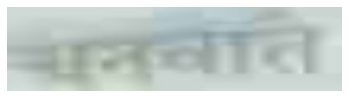

('Actual:', 'साथ', 'Prediction:', 'सर----------र', 'Prediction Corrected:', 'सरर')


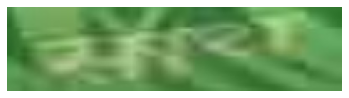

('Actual:', 'उसके', 'Prediction:', 'उस---------की', 'Prediction Corrected:', 'उसकी')


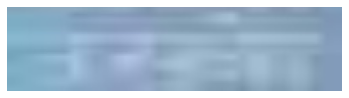

('Actual:', 'हर', 'Prediction:', 'प-----------र', 'Prediction Corrected:', 'पर')


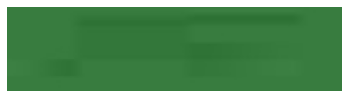

('Actual:', 'हर', 'Prediction:', 'प-----------र', 'Prediction Corrected:', 'पर')


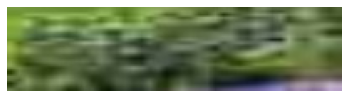

('Actual:', 'परभाव', 'Prediction:', 'पर-----माा--व', 'Prediction Corrected:', 'परमाव')


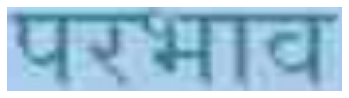

('Actual:', 'इसलिये', 'Prediction:', 'इस------लि-यय', 'Prediction Corrected:', 'इसलिय')


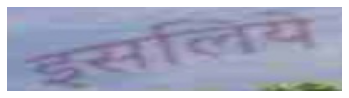

('Actual:', 'उसी', 'Prediction:', 'गय----------ी', 'Prediction Corrected:', 'गयी')


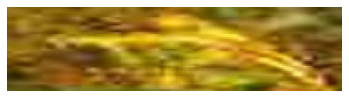

('Actual:', 'वही', 'Prediction:', 'रह----------ी', 'Prediction Corrected:', 'रही')


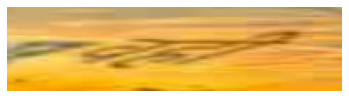

('Actual:', 'पथ', 'Prediction:', 'प-----------द', 'Prediction Corrected:', 'पद')


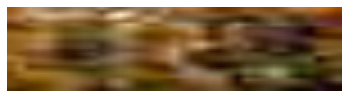

('Actual:', 'नए', 'Prediction:', 'ग-----------ए', 'Prediction Corrected:', 'गए')


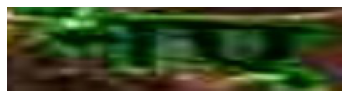

('Actual:', 'रहता', 'Prediction:', 'रह---------नी', 'Prediction Corrected:', 'रहनी')


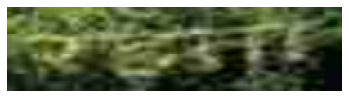

('Actual:', 'साथ', 'Prediction:', 'गा----------प', 'Prediction Corrected:', 'गाप')


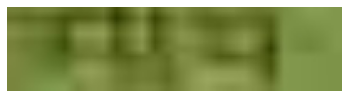

('Actual:', 'अवसर', 'Prediction:', 'क-----------र', 'Prediction Corrected:', 'कर')


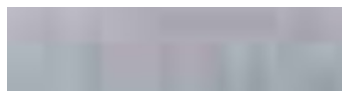

('Actual:', 'मन', 'Prediction:', 'त-----------ह', 'Prediction Corrected:', 'तह')


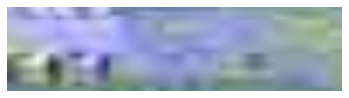

('Actual:', 'सच', 'Prediction:', 'स-----------ब', 'Prediction Corrected:', 'सब')


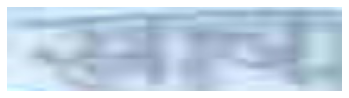

('Actual:', 'माफ', 'Prediction:', 'खा----------म', 'Prediction Corrected:', 'खाम')


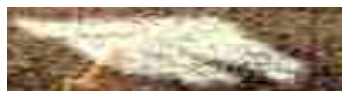

('Actual:', 'गरम', 'Prediction:', 'गर----------ण', 'Prediction Corrected:', 'गरण')


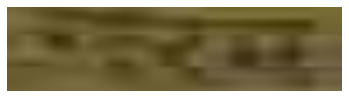

('Actual:', 'सर', 'Prediction:', 'प-----------र', 'Prediction Corrected:', 'पर')


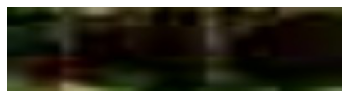

('Actual:', 'कम', 'Prediction:', 'रू----------प', 'Prediction Corrected:', 'रूप')


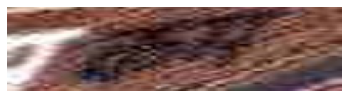

In [55]:
visualize_misclassifications('Test')

('Actual:', 'लाओ', 'Prediction:', 'जा----------ओ', 'Prediction Corrected:', 'जाओ')


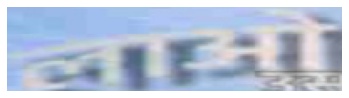

('Actual:', 'कठोरतम', 'Prediction:', 'कठ----ोर-ता-म', 'Prediction Corrected:', 'कठोरताम')


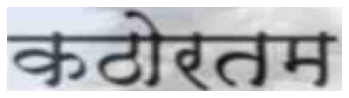

('Actual:', 'कण', 'Prediction:', 'क-----------ा', 'Prediction Corrected:', 'का')


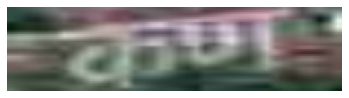

('Actual:', 'ताक', 'Prediction:', 'ना----------क', 'Prediction Corrected:', 'नाक')


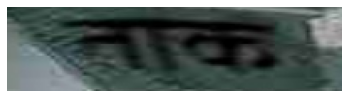

('Actual:', 'उछल', 'Prediction:', 'उछ---------ले', 'Prediction Corrected:', 'उछले')


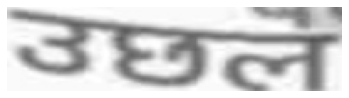

('Actual:', 'झटके', 'Prediction:', 'झर---------के', 'Prediction Corrected:', 'झरके')


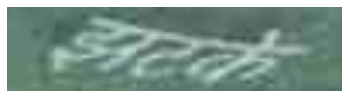

('Actual:', 'फफककर', 'Prediction:', 'फफ-----क--क-र', 'Prediction Corrected:', 'फककर')


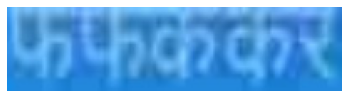

('Actual:', 'इसके', 'Prediction:', 'इस---------ने', 'Prediction Corrected:', 'इसने')


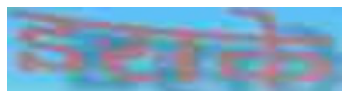

('Actual:', 'दृढ', 'Prediction:', 'ह-----------ट', 'Prediction Corrected:', 'हट')


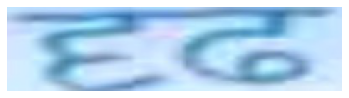

('Actual:', 'रुख', 'Prediction:', 'र-----------ख', 'Prediction Corrected:', 'रख')


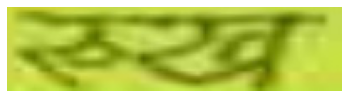

('Actual:', 'मर', 'Prediction:', 'भ-----------र', 'Prediction Corrected:', 'भर')


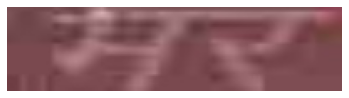

('Actual:', 'बदबू', 'Prediction:', 'बब--------बूू', 'Prediction Corrected:', 'बबू')


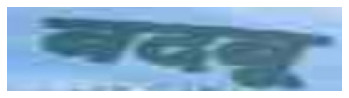

('Actual:', 'चार', 'Prediction:', 'बा----------र', 'Prediction Corrected:', 'बार')


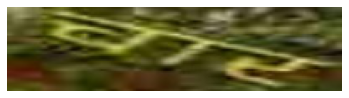

('Actual:', 'दुख', 'Prediction:', 'द-----------ख', 'Prediction Corrected:', 'दख')


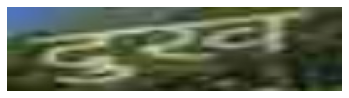

('Actual:', 'मन', 'Prediction:', 'प-----------र', 'Prediction Corrected:', 'पर')


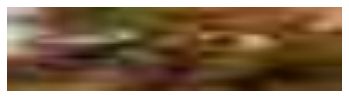

('Actual:', 'देख', 'Prediction:', 'हर---------ने', 'Prediction Corrected:', 'हरने')


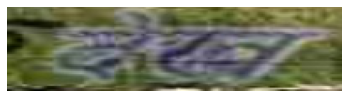

('Actual:', 'ऐसी', 'Prediction:', 'ऐस----------ा', 'Prediction Corrected:', 'ऐसा')


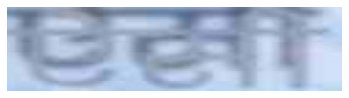

('Actual:', 'माल', 'Prediction:', 'भा----------ल', 'Prediction Corrected:', 'भाल')


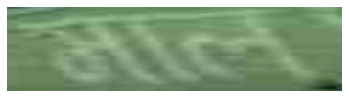

('Actual:', 'आमतौर', 'Prediction:', 'आ-----म-ती--र', 'Prediction Corrected:', 'आमतीर')


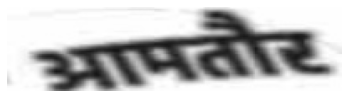

('Actual:', 'वोट', 'Prediction:', 'बो----------ट', 'Prediction Corrected:', 'बोट')


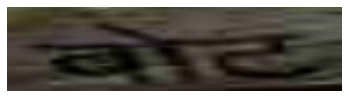

In [56]:
visualize_misclassifications('Test-V2')

### References:
[1] https://github.com/carnotaur/crnn-tutorial/

In [58]:
#test_result